In [3]:
import pandas as pd
import numpy as np
import random as rd
import seaborn as sns
from sklearn.decomposition import NMF
from random import random
import matplotlib.pyplot as plt

In [4]:
my_data=pd.read_csv('all_data_filtered.csv')
my_data.head(10)
my_data.index=my_data['Patient_id']

In [5]:
my_data=my_data.drop(['Patient_id'],axis=1)
my_data.head()

,ENSG00000223972,ENSG00000227232,ENSG00000243485,ENSG00000268020,ENSG00000240361,ENSG00000186092,ENSG00000238009,ENSG00000233750,ENSG00000237683,ENSG00000268903,...,ENSG00000244656,ENSG00000263760,ENSG00000264728,ENSG00000238667,ENSG00000238477,ENSG00000271726,ENSG00000215616,ENSG00000265557,ENSG00000238643,MRD Response
Patient_id,,,,,,,,,,,,,,,,,,,,,
165-06,0.000000,24.743294,0.0,0.0,0.0,0.0,0.015504,0.029030,0.249525,0.000000,...,0.0,0.0,2.666607,1.999955,0.674782,0.0,0.0,0.0,0.0,0.0
031-31,0.000000,18.281501,0.0,0.0,0.0,0.0,0.000000,0.087378,11.042994,1.078417,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0
069-02,0.062838,32.815619,0.0,0.0,0.0,0.0,0.000000,0.361829,27.015709,3.799909,...,0.0,0.0,0.000000,2.658880,2.018479,0.0,0.0,0.0,0.0,1.0
007-08,0.000000,17.226358,0.0,0.0,0.0,0.0,0.000000,0.018849,1.107071,0.190335,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
034-24,0.000000,13.274798,0.0,0.0,0.0,0.0,0.031994,0.039939,0.171643,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0


In [6]:
y=my_data['MRD Response']
X=my_data.drop(['MRD Response'],axis=1)

In [7]:
X.shape

(491, 53966)

### Correlations analysis:

In [58]:
CorrPatients=np.corrcoef(my_data)
#CorrGenes=np.corrcoef(my_data.T)

In [ ]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

plt.figure(figsize=(12,5))
dissimilarity = 1 - abs(CorrPatients)
print(dissimilarity.shape)
Z = linkage(squareform(X=dissimilarity), 'complete')

dendrogram(Z, X.columns, orientation='top', 
           leaf_rotation=90)

### NMF :

In [8]:
n_samples=X.shape[0]
n_genes=X.shape[1]

In [15]:
class nmf_model():
    def __init__(self,X) :
        self.data=X
        self.n_runs=100
        self.A_k=None
        self.best_k=None
        self.delta_k=None
        self.best_k=None
    
    #Returns consensus matrix, which is the averaged connectivity matrix on several runs of the algorithm
    def get_consensus_matrix(self,n_components):
        model=NMF(n_components,init='random')
        Cons_matrix=np.zeros((n_samples,n_samples))
        for i in range (self.n_runs):
            W=model.fit_transform(self.data)
            H=model.components_
            n_metagenes=H.shape[0]

            #calculate Connectivity matrix
            clusters=np.zeros(n_samples)
            C=np.zeros((n_samples,n_samples))

            for i in range (n_samples):
                clusters[i]=np.argmax(H[:,i])

            for i in range (n_samples):
                for j in range (i,n_samples):
                    if (clusters[i]==clusters[j]):
                        C[i,j]=1
                    else:
                        C[i,j]=0
        
            Cons_matrix=Cons_matrix+C
            return Cons_matrix/self.n_runs
        
    #To evaluate model stability
    def get_consensus_distribution (self,Cons_matrix):
        list_entries=Cons_matrix.ravel()
        hist, bins=np.histogram(list_entries, density=True)
        #calculate CDF
        cdf=np.cumsum(hist)
        fig, (ax1,ax2)=plt.subplots(1,2)        
        ax1.hist(list_entries)
        ax2.plot(bins[1:],cdf,label='CDF')
        plt.show()
        return bins, hist, cdf

    def model_selection(self):
        list_k=[10,1000,10000]
        self.A_k=np.zeros(len(list_k))
        for i in range(len(list_k)):
            Ck=self.get_consensus_matrix(list_k[i])
            bins,hist,cdf=self.get_consensus_distribution(Ck)
            self.A_k[i] = np.sum(h*(b-a) for b,a,h in zip(bins[1:],bins[:-1],cdf))
        #differences between areas under CDFs
        self.delta_k=np.array([(Ab-Aa)/Aa if i>2 else Aa 
                               for Ab,Aa, i in zip(self.A_k[1:],self.A_k[:,-1],range(len(list_k)))])
        self.best_k=np.argmax(self.deltaK)
        

In [16]:
my_model=nmf_model(X)

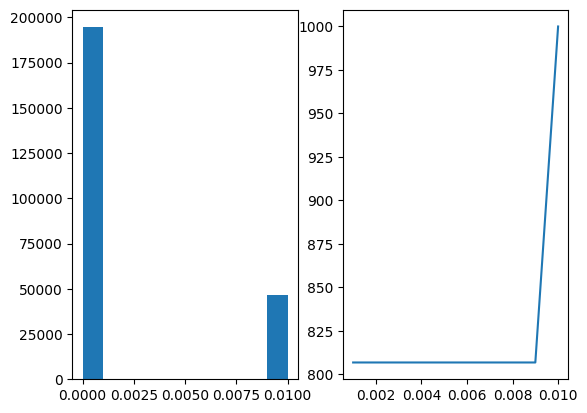

/tmp/ipykernel_117289/2387647673.py:54: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  self.A_k[i] = np.sum(h*(b-a) for b,a,h in zip(bins[1:],bins[:-1],cdf))


In [17]:
my_model.model_selection()

In [36]:
C=my_model.get_consensus_matrix(n_components=10)

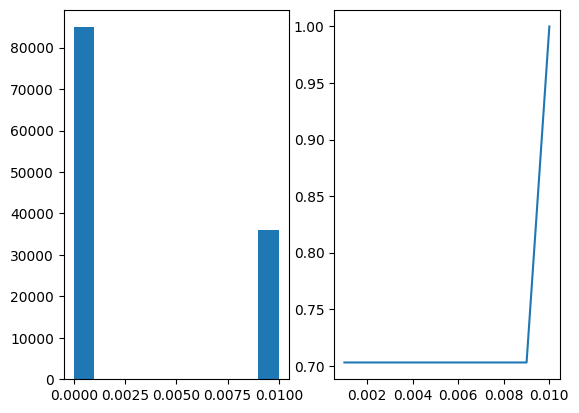

array([0.70290431, 0.70290431, 0.70290431, 0.70290431, 0.70290431,
       0.70290431, 0.70290431, 0.70290431, 0.70290431, 1.        ])

In [37]:
my_model.get_consensus_distribution(C)

In [38]:
model_2=nmf_model(X)
C_2=model_2.get_consensus_matrix(n_components=100)

/home/syrine/.local/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


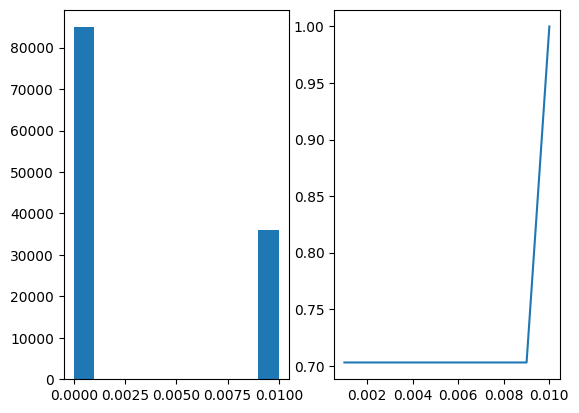

array([0.70290431, 0.70290431, 0.70290431, 0.70290431, 0.70290431,
       0.70290431, 0.70290431, 0.70290431, 0.70290431, 1.        ])

In [39]:
model_2.get_consensus_distribution(C)

In [58]:
def nmf (X,n_components,n_runs):
    model =NMF(n_components=100, init="random", random_state=0)
    C_all_runs=np.zeros((n_samples,n_samples))
    for n in range (n_runs):
        W=model.fit_transform(X)
        H=model.components_
        n_metagenes=H.shape[0]
        #calculate Connectivity matrix
        clusters=np.zeros(n_samples)
        C=np.zeros((n_samples,n_samples))
        for i in range (n_samples):
            clusters[i]=np.argmax(H[:,i])
        for i in range (n_samples):
            for j in range (i,n_samples):
                if (clusters[i]==clusters[j]):
                    C[i,j]=1
                else:
                    C[i,j]=0
        C_all_runs=C_all_runs+C
        return C_all_runs/n_runs

In [60]:
def nmf_selection(X,n_runs,k_list):
    C_k=[]
    for k in k_list:
        C_k.append(nmf(X,k,n_runs))
    return C_k
    

In [62]:
nmf_selection(X,5,[10,100,1000])

/home/irit/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/irit/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/home/irit/.local/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[array([[0.2, 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0.2, 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0.2, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0. , ..., 0. , 0. , 0.2]]),
 array([[0.2, 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0.2, 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0.2, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0. , ..., 0. , 0. , 0.2]]),
 array([[0.2, 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0.2, 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0.2, ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0.2, 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0.2, 0.2],
        [0. , 0. , 0. , ..., 0. , 0. , 0.2]])]

In [44]:
import numpy as np
from sklearn.decomposition import NMF
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, cophenet

# Generate some sample data
X = np.random.rand(100, 10)
# Apply NMF to the data
model = NMF(n_components=2, init='random', random_state=0)
X = model.fit_transform(X)
H=model.components_
# Calculate pairwise distance matrix
dist_matrix = pdist(X)
print(dist_matrix)
# Apply hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='ward')
# Calculate cophenetic correlation coefficient
coph_corr, coph_dist = cophenet(linkage_matrix, dist_matrix)

print("Cophenetic correlation coefficient:", coph_corr)

[0.12858969 0.26749319 0.25900064 ... 0.36426651 0.2064698  0.20678569]
Cophenetic correlation coefficient: 0.6318492580993474


In [ ]:
# Apply hierarchical clustering
linkage_matrix = linkage(dist_matrix, method='ward')